# 과제 1
- TODO로 표시된 함수 및 변수 선언 부분을 설명에 맞게 코드로 완성할 것
    - TODO이외의 부분을 수정하지 않아도 코드가 작동함
- 제출은 {이름}_과제1.ipynb로 저장하여 제출
  - 코랩에서 작업 후 메뉴바- 파일/다운로드 ipynb 
- 제출 전 메뉴바-런타임/다시 시작 및 모두 실행 했을 때 정상 작동하는 것을 꼭 확인
- 출제된 베이스 코드에 오타 및 에러 보고 시 가산점

In [1]:
import matplotlib.pyplot as plt
import IPython.display as ipd
import torch
from math import pi
import math
import torchaudio
import numpy as np
SR = 16000

## 문제 1: Pitch Scale 변환 및 음계 생성 (5점)
- Hz는 선형적인 스케일을 가진 주파수 단위
  - 일초에 같은 파형이 몇번 반복되는지를 나타냄
- MIDI Pitch는 가온 다(C4)를 60으로 하고 서양음계에서의 반음 차이를 1로 두는 단위
  - 서양음계에서 한 옥타브는 12개의 반음으로 이루어져있음
  - 한 옥타브 차이의 음은 MIDI Pitch상 12 만큼 차이남
  - 피아노 건반의 88개 음은 MIDI Pitch 21에서 시작해 108로 끝나는 정수에 해당함 
<img src=https://newt.phys.unsw.edu.au/jw/graphics/notesinvert.GIF>

- Hz를 Pitch로 변환하는 식 (평균율 기준)
  - $f(h) = \log_2(\frac{h}{440}) \times 12 + 69 $
  - h: Hz 
- MIDI Pitch를 Hz로 변환하는 식 (평균율 기준)
  - $f(\text{p})= 440 \times 2^{\frac{p-69}{12}}$
  - p: MIDI Pitch
  - f(p): MIDI Pitch에 해당하는 Hz
  - p=69일 때 f(p)=440Hz이며, p가 1늘어날 때마다 주파수가 $\times 2^{\frac{1}{12}}$ 비율로 증가함

In [2]:
from math import log
def hz_to_midi_pitch(frequency):
  '''
  입력: 음높이의 Hz 단위 주파수 (float)

  출력: 입력 음높이를 MIDI Pitch Scale로 변환한 값 (float). 반올림할 필요 없음
  '''
  
  f_h = math.log(frequency / 440, 2) * 12 + 69 

  # TODO: 주어진 입출력 형식과 내용을 만족하는 함수를 완성하시오
  return f_h


def midi_pitch_to_hz(midi_pitch):
  '''
  입력: 음높이의 MIDI Pitch Scale (float)

  출력: 입력 음높이를 Hz로 변환한 값 (float)
  '''
  # TODO: 주어진 입출력 형식과 내용을 만족하는 함수를 완성하시오
  
  f_p = 440 * 2 ** ((midi_pitch - 69) / 12)
  return f_p

for harmonic_index in range(1,10):
  test_freq = 440 * harmonic_index
  print(f'{test_freq} Hz is {hz_to_midi_pitch(test_freq):.2f} in MIDI Pitch')

for midi_pitch in range(60, 73):
  print(f'{midi_pitch} in MIDI Pitch is {midi_pitch_to_hz(midi_pitch):.2f} Hz')

440 Hz is 69.00 in MIDI Pitch
880 Hz is 81.00 in MIDI Pitch
1320 Hz is 88.02 in MIDI Pitch
1760 Hz is 93.00 in MIDI Pitch
2200 Hz is 96.86 in MIDI Pitch
2640 Hz is 100.02 in MIDI Pitch
3080 Hz is 102.69 in MIDI Pitch
3520 Hz is 105.00 in MIDI Pitch
3960 Hz is 107.04 in MIDI Pitch
60 in MIDI Pitch is 261.63 Hz
61 in MIDI Pitch is 277.18 Hz
62 in MIDI Pitch is 293.66 Hz
63 in MIDI Pitch is 311.13 Hz
64 in MIDI Pitch is 329.63 Hz
65 in MIDI Pitch is 349.23 Hz
66 in MIDI Pitch is 369.99 Hz
67 in MIDI Pitch is 392.00 Hz
68 in MIDI Pitch is 415.30 Hz
69 in MIDI Pitch is 440.00 Hz
70 in MIDI Pitch is 466.16 Hz
71 in MIDI Pitch is 493.88 Hz
72 in MIDI Pitch is 523.25 Hz


## 문제2: 코드 및 음계 합성하기 (20점)
- 주어진 make_sine_wave 및 문제1번에서 완성한 함수를 활용하여 아래 함수들을 완성하시오

In [3]:
class Oscilator:
    def __init__(self, freq, amp, sr):
        self.freq = torch.tensor(freq)
        self.amp = torch.tensor(amp)
        self.sr = sr

    def generate(self, dur):
        return make_sine_wave(self.freq, self.amp, dur, self.sr)

def make_sine_wave(freq, amp, dur, sr):
    num_samples = dur * sr
    time_frame = torch.arange(num_samples)
    time_frame_sec = time_frame / sr
    if freq.dim() == 1:
        freq = freq.unsqueeze(-1)
    if amp.dim() == 1:
        amp = amp.unsqueeze(-1)
    return amp * torch.sin(2 * pi * freq * time_frame_sec)

def generate_multi_pitch_tone(pitch_list, amp_list, duration, sr):
    '''
    입력: pitch_list: List of length n that contains n number of MIDI Pitch 
                    n 개의 MIDI Pitch 정수를 포함하고 있는 리스트 (n>=2)
        amp_list : List of length n that contains amplitude for each pitch   (0<amp<=1)
                    pitch_list에 있는 n개의 MIDI Pitch 각각에 해당하는 amplitude 
                    (각각의 amplitude는0보다 크고 1보다 작거나 같음)
        duration: 출력되는 소리의 길이 (float)
        sr: sampling rate

    출력: 입력으로 주어진 리스트 속에 있는 모든 pitch가 포함된 오디오 샘플 (sample_rate=sr, torch.Tensor 형태)

            예) 입력:  
            pitch_list = [60, 64, 67]
            amp_list = [1, 0.7, 0.5]
            출력: MIDI Pitch 60이며 amplitude가 1인 소리, Pitch 64이며 amp 0.7인 소리, 
                Pitch 67이며 amp 0.5인 소리 세 개가 duration만큼 동시에 재생되는 오디오 샘플 
        
    '''
    assert len(pitch_list) == len(amp_list)
    # TODO: 주어진 입출력 형식과 내용을 만족하는 함수를 완성하시오
    pitch_tensor = torch.tensor(pitch_list)
    amp_tensor = torch.tensor(amp_list)
    f_hz_tensor = midi_pitch_to_hz(pitch_tensor)
    sine_wave_tensor = make_sine_wave(f_hz_tensor, amp_tensor, duration, sr)

    return sine_wave_tensor.mean(axis=0)

`generate_multi_pitch_tone`을 완성하면 다음 코드를 실행하여 C장조 코드 (도,미,솔)이 생성되는지 확인한다

In [4]:
c_major_chord = [60, 64, 67]
amp_list = [1, 1, 1]
chord_tone = generate_multi_pitch_tone(c_major_chord, amp_list, 3, sr=SR)
ipd.Audio(chord_tone, rate=SR)

In [5]:
[1]

[1]

In [6]:
def make_major_scale_hz_sequence(midi_pitch):
    '''
    입력: 음높이의 MIDI Pitch Scale (float)

    출력 (list of float): 입력된 MIDI Pitch를 1음(Do)으로 하는 장음계 8개의 음의 Hz
    Hint: 장음계는 3음과 4음 (Mi, Fa) 사이가 반음, 7음과 8음 (Si, Do) 사이가 반음이며 나머지는 모두 온음 간격이다. 

    예: 입력이 60 (C4)라면, C4, D4, E4, F4, G4, A4, B4, C5에 해당하는 음고 Hz를 list로 출력한다. 
    '''
  # TODO: 주어진 입출력 형식과 내용을 만족하는 함수를 완성하시오
 
    if not isinstance(midi_pitch, list):
        midi_pitch = [midi_pitch]

    for i in range(7):
        if i == 2 or i == 6:
            midi_pitch.append(midi_pitch[-1] + 1) 
        else:
            midi_pitch.append(midi_pitch[-1] + 2) 
  
    f_hz = midi_pitch_to_hz(torch.tensor(midi_pitch))

    return f_hz


def generate_sequence_of_pitch(alist_of_hz, duration, sr):
    '''
    입력: 
        alist_of_hz (list): A list of float (Hz)
        duration (float): Duration of each frequency (seconds)

    출력: 입력으로 주어진 리스트 속에 있는 모든 Hz가 순서대로 등장하는 오디오 샘플 (sample_rate=sr, torch.Tensor 형태)

    예) 입력:  
            alist_of_hz = [440, 660, 880]
            duration = 1
            출력: 440 Hz 사인파가 1초 동안 재생된 뒤 660 Hz 사인파가 1초 동안 재생된 뒤 880 Hz 사인파가 1초 동안 재생되는 오디오 샘플
    '''
    # TODO: 주어진 입출력 형식과 내용을 만족하는 함수를 완성하시오
    os_list = []
    for freq in alist_of_hz:
        os_list.append(Oscilator(freq, amp=1, sr=sr).generate(duration))
    os_list = torch.cat(os_list, dim=0)
    print(os_list)
    return os_list

fund_note = 69 # MIDI pitch for A4
major_scale_in_hz = make_major_scale_hz_sequence(fund_note)
scale_sine = generate_sequence_of_pitch(major_scale_in_hz, duration=0.5, sr=SR)

ipd.display(ipd.Audio(scale_sine, rate=SR))

tensor([ 0.0000,  0.1719,  0.3387,  ..., -0.8607, -0.6374, -0.3386])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


## 문제 3: 순정률 (Just Intonation) vs 평균율 (Equal Temperament) (5점)
- 음고가 2배가 되면 같은 음으로 인지되는 것을 옥타브라고 한다.
  - 한 옥타브 안에 있는 음표들 끼리 어떤 음고 비율을 가지게 만들까?
- [순정률](https://ko.wikipedia.org/wiki/%EC%88%9C%EC%A0%95%EB%A5%A0)은 각각의 음고 (Hz) 관계가 정수배로 표현되는 조율법 의미한다.
  - 정수배 비율로 표현된다는 것은 유리수, 즉 분모와 분자가 정수인 분수로 표현할 수 있다는 말이다.
  - 순정 8도는 근음과 높은음의 음고 비율이 1:2가 되는 관계다.
  - 순정 5도는 근음과 높은음의 음고 비율이 2:3이 되는 관계다
  - 순정 장3도는 근음과 높은음의 음고 비율이 4:5가 되는 관계다.
  - 순정 단3도는 근음과 높은음의 음고 비율이 5:6이 되는 관계다.
- 평균율은 한 옥타브를 12개의 반음으로 쪼개고 각각의 반음 간의 음고 비율이 모두 일정하게 만든다.
  - 반음 끼리의 주파수 비율은 $2^{\frac{1}{12}}$
  - 화음을 만들때 음끼리 정확한 정수배가 되지 않는다

In [7]:
def make_just_intonation_triad_in_midi_pitch(fundamental_pitch):
    '''
    This function takes a fundamental_pitch in MIDI pitch then returns a list of three MIDI pitch
    that corresponds to major triad for a given fundamental frequency

    fundamental_pitch: 근음의 음고 MIDI Pitch
    output= [근음의 MIDI_pitch, 근음 순정 장3도의 MIDI_Pitch, 근음기준 순정 5도의 MIDI Pitch]
    '''

    # TODO: 주어진 입출력 형식과 내용을 만족하는 함수를 완성하시오
    output_list = []

    output = torch.tensor([fundamental_pitch, fundamental_pitch * 5 / 4, fundamental_pitch * 3 / 2])

    return output


'''
다음 예제는 순정율로 만든 장화음 소리와 평균율로 만들어진 장화음 소리를 비교하는 것이다.
순정율 함수를 정확하게 구현하였다면 평균율에 비해서 맥놀이 없이 안정적인 소리가 재생된다. 
'''
fund_pitch = 60
just_intonation_chord = make_just_intonation_triad_in_midi_pitch(fund_pitch)
amp_list = [1, 1, 1]
just_chord_tone = generate_multi_pitch_tone(just_intonation_chord, amp_list, 3, sr=SR)
print(f'Below is the Chord Tone with Just Intonation ({just_intonation_chord:})')
ipd.display(ipd.Audio(just_chord_tone, rate=SR))

equal_temperament_chord = [fund_pitch, fund_pitch+4, fund_pitch+7]
equal_chord_tone = generate_multi_pitch_tone(equal_temperament_chord, amp_list, 3, sr=SR)
print(f'Below is the Chord Tone with Equal Temperament  ({equal_temperament_chord}). You can hear beat(맥놀이).')
ipd.display(ipd.Audio(equal_chord_tone, rate=SR))

Below is the Chord Tone with Just Intonation (tensor([60., 75., 90.]))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Below is the Chord Tone with Equal Temperament  ([60, 64, 67]). You can hear beat(맥놀이).


## 문제3: 셰퍼드 톤 합성하기 (20점)
- [셰퍼드 톤 설명 영상](https://youtu.be/LVWTQcZbLgY)
- 사람이 소리의 높이와 세기를 어떻게 인지하는지를 고려하여 완성한다.

In [8]:
torch.logspace(1, 0, 12).repeat(2)

tensor([10.0000,  8.1113,  6.5793,  5.3367,  4.3288,  3.5112,  2.8480,  2.3101,
         1.8738,  1.5199,  1.2328,  1.0000, 10.0000,  8.1113,  6.5793,  5.3367,
         4.3288,  3.5112,  2.8480,  2.3101,  1.8738,  1.5199,  1.2328,  1.0000])

In [9]:
class ShepardToneGenerator:
    def __init__(self, fundamental_pitch, sr, dur_per_step, num_iteration):
        self.sr = sr #sampling rate
        self.dur = dur_per_step # 한 음 당 길이 (초) 
        self.iter = num_iteration # 전체 시퀀스를 몇번 반복할 것인지
        self.fadeout_margin = self.dur*0.1 # 음 끝의 페이드아웃 길이
        
        self.fundamental_pitch = fundamental_pitch

        self.pitch_combinations = self.define_pitch()
        self.amplitude_combinations = self.define_amplitude()
    
    def define_pitch(self):
        '''
        입력: 없음

        출력: List of List of MIDI pitch의 Tensor형태 
            MIDI Pitch 리스트들의 리스트
            (예: [ [60, 64, 67], [61, 65, 68], [62, 66, 69] ])
        '''
        # output = torch.zeros([24, 3]) # 24 note combinations with 3 notes each
        # TODO: 셰퍼드 톤을 만들기 위한 output을 완성하시오
        fundamental_pitch = self.fundamental_pitch
        fundamental_pitch = torch.tensor([fundamental_pitch - 12, fundamental_pitch, fundamental_pitch + 12])
        up_pitch = torch.tensor(np.arange(12)).unsqueeze(-1)
        output = (fundamental_pitch + up_pitch).repeat(2, 1)
        print(output)

        return output

    def define_amplitude(self):
        '''
        입력: 없음

        출력: List of List of amplitude의 Tensor형태 
            self.pitch_combinations의 각각에 해당하는 소리의 amplitude
            (예: [ [1.0, 0.2, 0.8], [1.0, 0.5, 0.5], [1.0, 0.8, 0.2] ])

        힌트: 사람이 듣는 소리의 크기는 amplitude의 log값에 비례하므로 amplitude를 이에 맞게 조절해야한다
        '''
        
        output = torch.zeros([24,3]) # 24 note combinations with 3 notes each
        end = 1
        # TODO: 셰퍼드 톤을 만들기 위한 output을 완성하시오
        output[:, 0] = torch.logspace(0, end, 12).repeat(2)
        output[:, 1] = torch.ones((24)) * torch.tensor(10 ** end)
        output[:, 2] = torch.logspace(end, 0, 12).repeat(2)

        print(output)

        return output

    def generate(self):
        outputs = []
        for i in range(self.iter):
            for j in range(len(self.pitch_combinations)):
                current_pitches = self.pitch_combinations[j]
                current_amplitudes = self.amplitude_combinations[j]
                audio = generate_multi_pitch_tone(current_pitches, current_amplitudes, self.dur, self.sr)
                audio[-int(self.fadeout_margin*self.sr):] *= torch.logspace(0, -3, int(self.fadeout_margin*self.sr))
                outputs.append(audio)
        return torch.cat(outputs, dim=-1)


fundamental_pitch = 60
shetone = ShepardToneGenerator(fundamental_pitch, SR, 0.3, 3)
shepard_audio = shetone.generate()
ipd.Audio(shepard_audio, rate=SR)

tensor([[48, 60, 72],
        [49, 61, 73],
        [50, 62, 74],
        [51, 63, 75],
        [52, 64, 76],
        [53, 65, 77],
        [54, 66, 78],
        [55, 67, 79],
        [56, 68, 80],
        [57, 69, 81],
        [58, 70, 82],
        [59, 71, 83],
        [48, 60, 72],
        [49, 61, 73],
        [50, 62, 74],
        [51, 63, 75],
        [52, 64, 76],
        [53, 65, 77],
        [54, 66, 78],
        [55, 67, 79],
        [56, 68, 80],
        [57, 69, 81],
        [58, 70, 82],
        [59, 71, 83]])
tensor([[ 1.0000, 10.0000, 10.0000],
        [ 1.2328, 10.0000,  8.1113],
        [ 1.5199, 10.0000,  6.5793],
        [ 1.8738, 10.0000,  5.3367],
        [ 2.3101, 10.0000,  4.3288],
        [ 2.8480, 10.0000,  3.5112],
        [ 3.5112, 10.0000,  2.8480],
        [ 4.3288, 10.0000,  2.3101],
        [ 5.3367, 10.0000,  1.8738],
        [ 6.5793, 10.0000,  1.5199],
        [ 8.1113, 10.0000,  1.2328],
        [10.0000, 10.0000,  1.0000],
        [ 1.0000, 10.0000, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [10]:
torch.ones((14)) * torch.tensor(10 ** (0.5))

tensor([3.1623, 3.1623, 3.1623, 3.1623, 3.1623, 3.1623, 3.1623, 3.1623, 3.1623,
        3.1623, 3.1623, 3.1623, 3.1623, 3.1623])

In [11]:
def make_major_scale_sequence(midi_pitch):
    '''
    입력: 음높이의 MIDI Pitch Scale (float)

    출력 (list of float): 입력된 MIDI Pitch를 1음(Do)으로 하는 장음계 8개의 음의 Hz
    Hint: 장음계는 3음과 4음 (Mi, Fa) 사이가 반음, 7음과 8음 (Si, Do) 사이가 반음이며 나머지는 모두 온음 간격이다. 

    예: 입력이 60 (C4)라면, C4, D4, E4, F4, G4, A4, B4, C5에 해당하는 음고 Hz를 list로 출력한다. 
    '''
  # TODO: 주어진 입출력 형식과 내용을 만족하는 함수를 완성하시오
 
    if not isinstance(midi_pitch, list):
        midi_pitch = [midi_pitch]

    for i in range(7):
        if i == 2 or i == 6:
            midi_pitch.append(midi_pitch[-1] + 1) 
        else:
            midi_pitch.append(midi_pitch[-1] + 2) 
  
    

    return torch.tensor(midi_pitch)

class ShepardToneGenerator:
    def __init__(self, fundamental_pitch, sr, dur_per_step, num_iteration):
        self.sr = sr #sampling rate
        self.dur = dur_per_step # 한 음 당 길이 (초) 
        self.iter = num_iteration # 전체 시퀀스를 몇번 반복할 것인지
        self.fadeout_margin = self.dur*0.1 # 음 끝의 페이드아웃 길이
        
        self.fundamental_pitch = fundamental_pitch

        self.pitch_combinations = self.define_pitch()
        self.amplitude_combinations = self.define_amplitude()
    
    def define_pitch(self):
        '''
        입력: 없음

        출력: List of List of MIDI pitch의 Tensor형태 
            MIDI Pitch 리스트들의 리스트
            (예: [ [60, 64, 67], [61, 65, 68], [62, 66, 69] ])
        '''
        output = torch.zeros([14, 3]) # 24 note combinations with 3 notes each
        # TODO: 셰퍼드 톤을 만들기 위한 output을 완성하시오
        fundamental_pitch = self.fundamental_pitch
        fundamental_pitch = [fundamental_pitch - 24, fundamental_pitch, fundamental_pitch + 24]
        for i, midi in enumerate(fundamental_pitch):
            output[:7, i] = make_major_scale_sequence(midi)[:-1]
            output[7:, i] = make_major_scale_sequence(midi + 12)[:-1]
        print(output)

        return output

    def define_amplitude(self):
        '''
        입력: 없음

        출력: List of List of amplitude의 Tensor형태 
            self.pitch_combinations의 각각에 해당하는 소리의 amplitude
            (예: [ [1.0, 0.2, 0.8], [1.0, 0.5, 0.5], [1.0, 0.8, 0.2] ])

        힌트: 사람이 듣는 소리의 크기는 amplitude의 log값에 비례하므로 amplitude를 이에 맞게 조절해야한다
        '''

        output = torch.zeros([14,3]) # 24 note combinations with 3 notes each
        end = 1
        # TODO: 셰퍼드 톤을 만들기 위한 output을 완성하시오
        output[:, 0] = torch.logspace(0, end, 14)
        output[:, 1] = torch.ones((14)) * torch.tensor(10 ** (end))
        output[:, 2] = torch.logspace(end, 0, 14) 

        print(output)

        return output

    def generate(self):
        outputs = []
        for i in range(self.iter):
            for j in range(len(self.pitch_combinations)):
                current_pitches = self.pitch_combinations[j]
                current_amplitudes = self.amplitude_combinations[j]
                audio = generate_multi_pitch_tone(current_pitches, current_amplitudes, self.dur, self.sr)
                audio[-int(self.fadeout_margin*self.sr):] *= torch.logspace(0, -3, int(self.fadeout_margin*self.sr))
                outputs.append(audio)
        return torch.cat(outputs, dim=-1)


fundamental_pitch = 60
shetone = ShepardToneGenerator(fundamental_pitch, SR, 0.3, 3)
shepard_audio = shetone.generate()
ipd.Audio(shepard_audio, rate=SR)

tensor([[ 36.,  60.,  84.],
        [ 38.,  62.,  86.],
        [ 40.,  64.,  88.],
        [ 41.,  65.,  89.],
        [ 43.,  67.,  91.],
        [ 45.,  69.,  93.],
        [ 47.,  71.,  95.],
        [ 48.,  72.,  96.],
        [ 50.,  74.,  98.],
        [ 52.,  76., 100.],
        [ 53.,  77., 101.],
        [ 55.,  79., 103.],
        [ 57.,  81., 105.],
        [ 59.,  83., 107.]])
tensor([[ 1.0000, 10.0000, 10.0000],
        [ 1.1938, 10.0000,  8.3768],
        [ 1.4251, 10.0000,  7.0170],
        [ 1.7013, 10.0000,  5.8780],
        [ 2.0309, 10.0000,  4.9239],
        [ 2.4245, 10.0000,  4.1246],
        [ 2.8943, 10.0000,  3.4551],
        [ 3.4551, 10.0000,  2.8943],
        [ 4.1246, 10.0000,  2.4245],
        [ 4.9239, 10.0000,  2.0309],
        [ 5.8780, 10.0000,  1.7013],
        [ 7.0170, 10.0000,  1.4251],
        [ 8.3768, 10.0000,  1.1938],
        [10.0000, 10.0000,  1.0000]])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


## 문제4: Spectrogram Plot
- Spectrogram은 Short-time Fourier Transform을 이용하여 오디오 샘플을 시간에 따른 주파수별 에너지 변화로 표현한 2D 매트릭스이다.

- 문제 4번에서는 위에서 생성한 `shepard_audio`를 사용해도 되며 아래 코드를 실행해서 다른 오디오를 불러와도 괜찮다.

In [12]:
# Option 1
your_audio = shepard_audio

# Option 2
# your_audio = torchaudio.load("your_audiofile.wav")

### 문제 4-1: Spectrogram 생성 (10점)
- 주파수가 Linear Scale인 Spectrogram을 생성한다 
  - 주파수가 Linear Scale이라는 것은 주파수를 나타내는 y축에 표현된 등간격이 100, 200, 300, 400 처럼 등차수열로 커지는 것을 의미한다.
  - 주파수가 Log Scale로 표현되면 y축에 표현된 등간격이 100, 1000, 10000, 100000 처럼 등비수열로 커지는 것을 의미한다.

![image](https://i.stack.imgur.com/Jg5EG.png)
이 그림에서 K는 fft size에 해당하며 Q는 hop size에 해당한다.

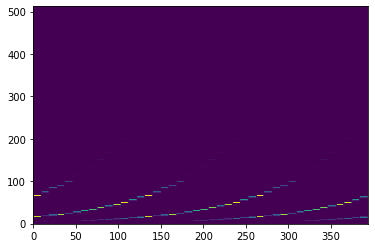

In [13]:
def get_spectrogram(audio, n_fft, hop_size):
  '''
  audio: 입력 오디오 샘플(torch.Tensor)
  n_fft: fft size. 한 번에 몇 개의 오디오 샘플을 푸리에 변환할지 결정
  hop_size: 오디오 

  출력: 오디오에 대해 fft_size = n_fft를 사용한 스펙트로그램 (torch.Tensor)
  '''

  # TODO: torchaudio.transforms.Spectrogram을 이용하여 들어온 audio 입력에 대해 
  # FFT Size(=Window Size, 특별한 언급이 없는 경우)가 n_fft인 스펙트로그램을 반환한다.


  return torchaudio.transforms.Spectrogram(n_fft=n_fft, hop_length=hop_size)(audio)

spec = get_spectrogram(your_audio, 1024, 512)
plt.imshow(spec, origin='below', aspect='auto', interpolation='nearest')

### 문제 3-2: Spectrogram 축의 값 변환 (20점)
- 위에서 그려진 그래프의 x축 y축의 레이블 값은 각각 Frame / Bin (칸) 인덱스를 의미한다.
  - `spec.shape`이 `torch.size([513, 1801])`이라면 이는 주파수 축으로 513개의 칸이 있고 시간 축으로는 1801개의 칸이 있다는 것을 의미한다. 
  - 예: x축 값 250은 스펙트로그램에서 250번째 시간축 칸을 의미한다. 
  - 예: y축 값 200은 200번째 주파수 칸을 의미한다.

- 시간 축과 주파수 축을 각각 초(second)와 Hz 단위로 변환하면 스펙트로그램의 데이터를 더 잘 이해할 수 있다.
- Spectrogram을 생성할 때 사용하였던 파라미터(n_fft, hop_size 등)를 이용하여 스펙트로그램 각각의 칸이 어떤 값을 의미하는지 변환할 수 있다.

- **Hint:** 함수가 올바르게 완성되었다면 아래 plot 코드를 실행했을 때 x축은 초 단위, y축은 Hz 단위로 나오게 된다.
  - 실제 오디오의 길이가 그래프 x축 가장 오른쪽 틱 레이블과 비슷한지 확인한다.
  - 그래프 y축 가장 위쪽 틱 레이블이 Sampling rate의 절반과 비슷한지 확인한다.
    - Nyquist's Theorem에 따라 샘플링 레이트 절반을 넘는 주파수는 관측할 수 없다.
    - 즉 STFT 결과에서 가장 높은 주파수 칸은 샘플링레이트 절반에 해당하는 주파수이다.

In [14]:
def frequency_bin_to_hz(bin_index, sr, n_fft):
    '''
    입력: bin_index: Spectrogram에서 frequency bin의 인덱스

    출력: sr,n_fft에 해당하는 스펙트로그램 frequency bin index의 frequency Hz
    '''
    # TODO: 함수를 완성하시오

    return 0.5 * sr / (n_fft // 2) * bin_index

def time_bin_to_second(bin_index, sr, n_fft, hop_size):
  '''
  입력: bin_index: Spectrogram에서 time bin의 인덱스
       sr: sampling rate
       n_fft: fft size
       hop_size: Spectrogram의 각 프레임이 입력 오디오 상에서 몇 오디오 샘플 씩 떨어져있는지를 나타냄 

  출력: sr,n_fft,hop_size에 해당하는 스펙트로그램 time bin index가 입력 오디오 몇 초에 해당하는지를 반환
  '''
  # TODO: 함수를 완성하시오


  return ((bin_index - 1) * hop_size + n_fft) / sr


def change_ytick_to_frequency(sr, n_fft):
  prev_yticks = plt.yticks()[0][1:-1] 
  ytick_labels= [frequency_bin_to_hz(bin_index, sr=sr, n_fft=n_fft) for bin_index in prev_yticks]
  plt.yticks(ticks=prev_yticks, labels=ytick_labels)

def change_xtick_to_seconds(sr, n_fft, hop_size):
  prev_xticks = plt.xticks()[0][1:-1]
  xtick_labels= [time_bin_to_second(bin_index, sr=sr, n_fft=n_fft, hop_size=hop_size) for bin_index in prev_xticks]
  plt.xticks(ticks=prev_xticks, labels=xtick_labels)


Text(0.5, 0, 'Time (seconds)')

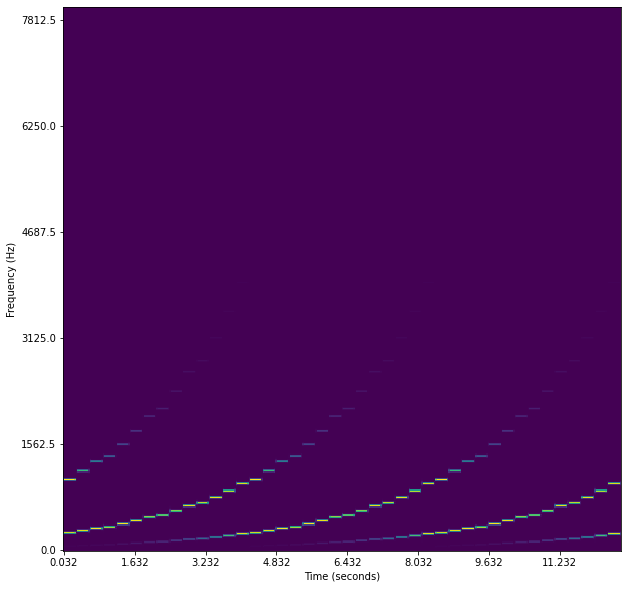

In [15]:
fft_size=1024
hop_size=512
spec = get_spectrogram(your_audio, fft_size, hop_size)

plt.figure(figsize=(10,10))
plt.imshow(spec, origin='below', aspect='auto', interpolation='nearest')
change_ytick_to_frequency(SR, fft_size)
change_xtick_to_seconds(SR, fft_size, hop_size)
plt.ylabel('Frequency (Hz)') 
plt.xlabel('Time (seconds)') 

### 문제 3-3 Mel Scale 생성 후 Mel Spectrogram 만들기 (5점)
- **주의**: 숙제 함수에서는 MelScale을 반환하여야함
  - 함수로 생성한 MelScale에 Spectrogram을 넣어 Mel Spectrogram을 생성하는 코드는 함수 바깥에 완성되어 있음
- f_min과 f_max값은 자신이 입력으로 사용하는 오디오에 맞춰 설정
  - 그래프 y축에서 빈공간이 많이 남으면 안됨

Text(0.5, 0, 'Time (seconds)')

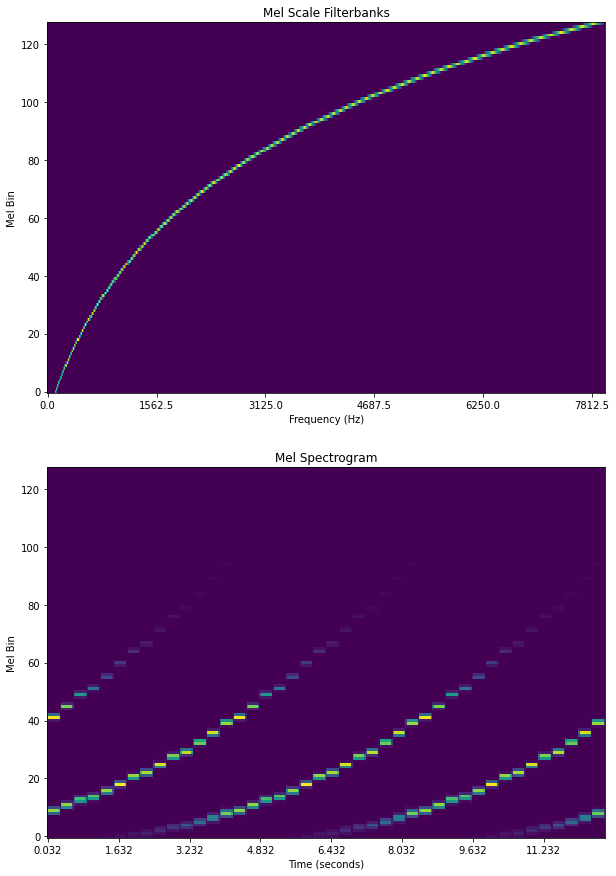

In [16]:
def make_mel_scale(n_mels, sr, n_spec_bins, f_min=None, f_max=None):
  '''
  입력: Linear Spectrogram (torch.Tensor)

  출력: Mel Scale (torch.nn.Module) (Linear Spectrogram을 입력으로 받아 Mel Scale 출력)
  '''
  # TODO: torchaudio.transforms.MelScale을 이용해 함수를 완성하시오
  # 
  return torchaudio.transforms.MelScale(n_mels=n_mels, sample_rate=sr, n_stft=n_spec_bins, f_min=f_min, f_max=f_max)

# TODO: f_min, f_max는 자신이 만든 오디오에 맞춰서 적당한 값을 입력해 그래프에서 빈 주파수가 없도록 설정
your_f_min = 100
your_f_max = SR // 2

mel_scale = make_mel_scale(128, SR, n_spec_bins=spec.shape[0], f_min=your_f_min, f_max=your_f_max)
mel_spec=mel_scale(spec)

# Plot
plt.figure(figsize=(10,15))
plt.subplot(2,1,1)
plt.imshow(mel_scale.fb.T, origin='below', aspect='auto', interpolation='nearest')
plt.title("Mel Scale Filterbanks")
prev_xticks = plt.xticks()[0][1:-1]
xtick_labels= [frequency_bin_to_hz(bin_index, sr=SR, n_fft=fft_size) for bin_index in prev_xticks]
applied_ticks = plt.xticks(ticks=prev_xticks, labels=xtick_labels)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Mel Bin")
plt.subplot(2,1,2)
plt.title("Mel Spectrogram")
plt.ylabel("Mel Bin")
plt.imshow(mel_spec, origin='below', aspect='auto', interpolation='nearest') 
change_xtick_to_seconds(SR, fft_size, hop_size)
plt.xlabel('Time (seconds)') 

### 문제 3-4 Amplitude to dB (5점)
- Amplitude Scale의 Spectrogram을 dB scale로 변경
- x축 y축의 스케일을 변경하는 것이 아니라 (x,y) 칸에 들어있는 모든 숫자들의 스케일을 dB로 변경

Text(0.5, 0, 'Mel Bin')

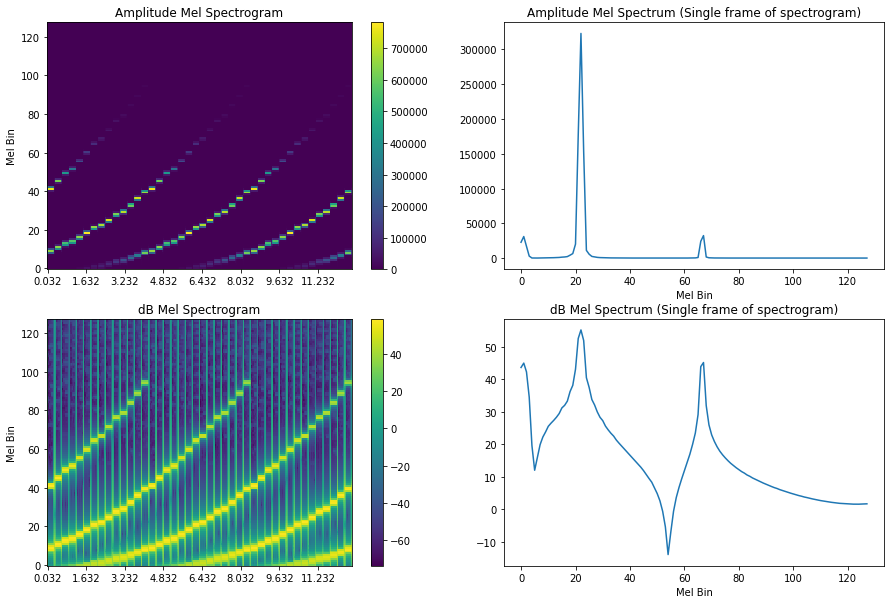

In [17]:
def convert_amplitude_to_db(spec):
  '''
  입력: Amplitude Spectrogram (torch.Tensor)

  출력: dB Spectrogram (torch.Tensor)
  '''
  # TODO: torchaudio.transforms.AmplitudeToDB를 이용해 함수를 완성하시오
  return torchaudio.transforms.AmplitudeToDB()(spec)

db_spec = convert_amplitude_to_db(mel_spec)

plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.title("Amplitude Mel Spectrogram")
plt.imshow(mel_spec, origin='below', aspect='auto', interpolation="nearest")
plt.colorbar()
change_xtick_to_seconds(SR, fft_size, hop_size)
plt.ylabel('Mel Bin')
plt.subplot(2,2,2)
plt.title("Amplitude Mel Spectrum (Single frame of spectrogram)")
plt.plot(mel_spec[:,mel_spec.shape[1]//2] )
plt.xlabel('Mel Bin')
plt.subplot(2,2,3)
plt.title("dB Mel Spectrogram")
plt.ylabel('Mel Bin')
plt.imshow(db_spec, origin='below', aspect='auto', interpolation="nearest")
change_xtick_to_seconds(SR, fft_size, hop_size)
plt.colorbar()
plt.subplot(2,2,4)
plt.title("dB Mel Spectrum (Single frame of spectrogram)")
plt.plot(db_spec[:,db_spec.shape[1]//2] )
plt.xlabel('Mel Bin')

### 문제 3-5 알맞은 FFT Size 고르기 (10점)
- FFT Size 변화에 따라 주파수 해상도와 시간 해상도가 어떻게 달라지는지 확인한다
- 자신이 스펙트로그램을 통해 보고싶은 정보가 어떤 것인지, 그리고 이를 위해서는 어떤 fft_size와 mel f_min, f_max를 선택해야하는지 아래에 기술한다.

In [18]:
!wget "https://pytorch-tutorial-assets.s3.amazonaws.com/steam-train-whistle-daniel_simon.wav"

--2022-03-28 12:19:51--  https://pytorch-tutorial-assets.s3.amazonaws.com/steam-train-whistle-daniel_simon.wav
Resolving pytorch-tutorial-assets.s3.amazonaws.com (pytorch-tutorial-assets.s3.amazonaws.com)... 54.231.202.241
Connecting to pytorch-tutorial-assets.s3.amazonaws.com (pytorch-tutorial-assets.s3.amazonaws.com)|54.231.202.241|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 437516 (427K) [audio/wav]
Saving to: ‘steam-train-whistle-daniel_simon.wav.1’

steam-train-whistle 100%[===================>] 427.26K  --.-KB/s    in 0.1s    

2022-03-28 12:19:51 (4.08 MB/s) - ‘steam-train-whistle-daniel_simon.wav.1’ saved [437516/437516]



/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:595: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (65) may be set too low.
  "At least one mel filterbank has all zero values. "


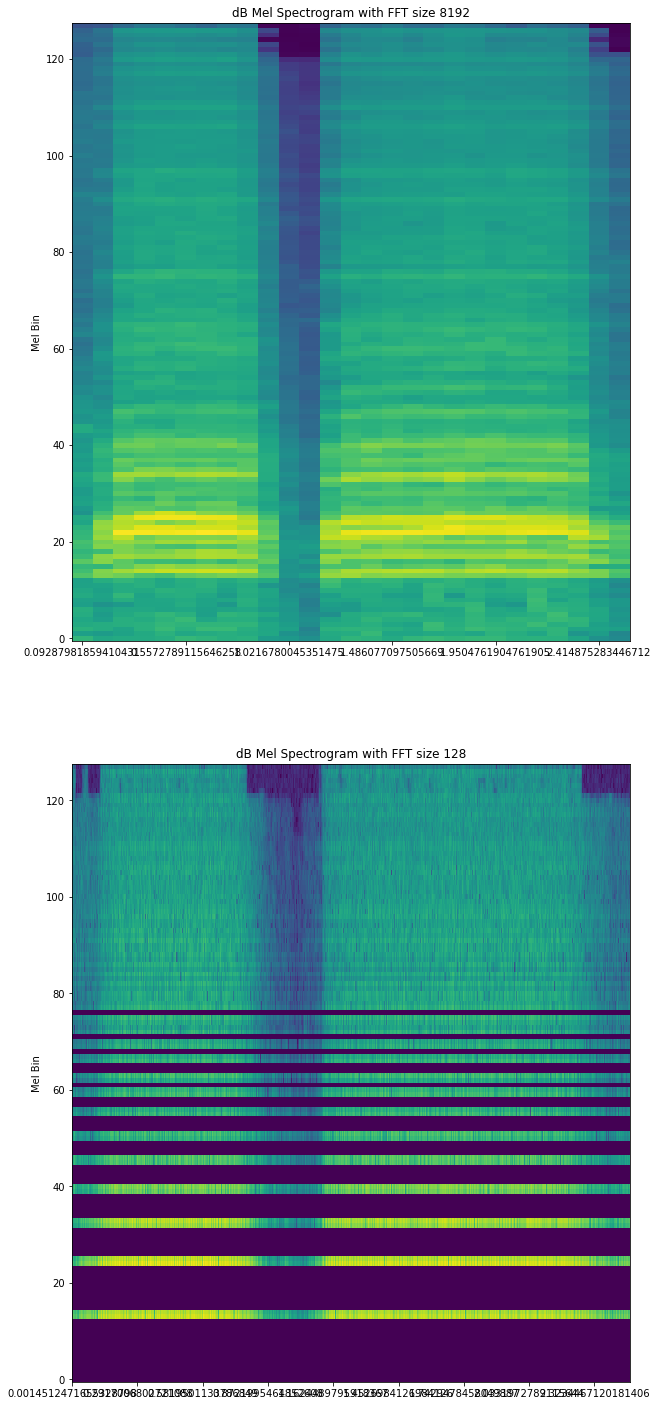

In [19]:
# TODO: 다양한 FFT size를 리스트 안에 넣어서 코드를 돌리고 확인해본다.
fft_size_list = [8192, 128] #예: fft_size_list=[128, 8192]

# TODO: 자신이 선택한 오디오를 업로드하고, FFT 사이즈에 따른 차이를 쉽게 보여줄 수 있는 구간을 잘라서 플롯한다.
# TODO: 특성을 잘 보여줄 수 있는 f_min, f_max를 선택한다.
your_audio, your_sr = torchaudio.load("steam-train-whistle-daniel_simon.wav")
your_audio = your_audio[:].mean(dim=0)
your_f_min = 20
your_f_max = 20000

plt.figure(figsize=(10,25))
for i, fft_size in enumerate(fft_size_list):
  hop_size = fft_size //2
  spec = get_spectrogram(your_audio, fft_size, hop_size)
  mel_scale = make_mel_scale(128, your_sr, n_spec_bins=spec.shape[0], f_min=your_f_min, f_max=your_f_max)
  mel_spec=mel_scale(spec)
  db_spec = convert_amplitude_to_db(mel_spec)
  plt.subplot(len(fft_size_list), 1, i+1)
  plt.title(f"dB Mel Spectrogram with FFT size {fft_size}")
  plt.ylabel('Mel Bin')
  plt.imshow(db_spec, origin='below', aspect='auto', interpolation="nearest")
  change_xtick_to_seconds(your_sr, fft_size, hop_size)


### 문제3-5 답안:
- 아래에 FFT 사이즈에 따라 어떤 정보들이 더 알기 쉬워지고 어떤 정보들이 알기 어려워지는 지를 

FFT 사이즈가 커진다면 주파수 성분에 대한 해상도가 높아진다(더 정밀한 주파수 분포를 얻을 수 있다.) => But 시간에 따른 주파수 변화를 관찰하기 어려워진다.       
FFT 사이즈가 작다면 => 주파수 성분의 해상도는 낮아지지만 시간 성분에 대한 해상력은 높아진다.